# Análisis de Conversaciones Conecta 2.0

**Objetivo**: Evaluar el desempeño del asistente virtual Conecta analizando patrones de respuesta, factores que generan respuestas nulas, y comportamiento de usuarios.

**Período analizado**: Septiembre - Octubre 2025

---

## 1. LIBRERÍAS

In [63]:
import os
import json
import time
import pandas as pd
from google.oauth2 import service_account
from google.cloud import aiplatform
from google.api_core import exceptions
from vertexai.generative_models import GenerativeModel, GenerationConfig
# Importamos solo lo que está disponible en tu versión de SDK

In [64]:
import re
import io
import csv
import numpy as np
from tqdm import tqdm
import zipfile

from dotenv import load_dotenv

# Data Science & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display
from wordcloud import WordCloud

# Deep Learning & Generative AI
import torch
import tensorflow as tf
import transformers
import openai
import google.generativeai as genai
from google import genai as google_genai
from google.genai import types

# NLP
import nltk
import spacy

# Data Handling
import openpyxl
from sqlalchemy import create_engine

# APIs & Auth
from googleapiclient.discovery import build

# Other utilities
import requests
from tenacity import retry
from google.cloud import bigquery

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

---

## 2. CARGA DE DATOS

Cargamos las conversaciones de Conecta+ desde archivos históricos y el ZIP más reciente del sistema.

#### CONECTA+

In [65]:
RUTA_HISTORICO = "../Resultados_Historicos/df_resultados.csv"
conecta_2_evaluados = pd.read_csv(RUTA_HISTORICO, sep=',')

conecta_2_evaluados.conversation_id = conecta_2_evaluados.conversation_id.astype(int)

In [66]:
def parse_csv_with_multiline_fields(file_path):
    """
    Parse CSV file that has newlines within quoted fields.
    Handles CSV-escaped quotes (doubled quotes: "").
    
    Uses a character-by-character state machine approach:
    - Tracks quote state to know when we're inside/outside quoted fields
    - Handles escaped quotes ("" becomes ")
    - Accumulates lines until complete record is found
    """
    records = []
    current_record = []
    current_field = []
    in_quotes = False
    header = None
    prev_char = ''

    with open(file_path, 'r', encoding='utf-8') as f:
        char_iter = iter(lambda: f.read(1), '')

        for char in char_iter:
            if char == '"':
                # Check if this is an escaped quote (doubled: "")
                if prev_char == '"' and in_quotes:
                    # This is an escaped quote - add one quote to field
                    current_field.append('"')
                    prev_char = ''  # Reset to avoid triple-quote issues
                    continue
                else:
                    # Toggle quote state
                    in_quotes = not in_quotes
                    prev_char = char
                    continue

            if not in_quotes:
                if char == ',':
                    # End of field
                    current_record.append(''.join(current_field))
                    current_field = []
                elif char == '\n':
                    # End of record
                    if current_field or current_record:
                        current_record.append(''.join(current_field))
                        current_field = []

                        if header is None:
                            header = current_record
                        else:
                            if len(current_record) == len(header):
                                records.append(current_record)
                        current_record = []
                else:
                    current_field.append(char)
            else:
                # Inside quotes - add everything including newlines
                current_field.append(char)

            prev_char = char

        # Handle last field/record
        if current_field or current_record:
            current_record.append(''.join(current_field))
            if len(current_record) == len(header):
                records.append(current_record)

    df = pd.DataFrame(records, columns=header)
    return df

In [ ]:
# --- Constantes ---
ARCHIVOS_OBJETIVO = [
    'tbl_conversaciones_conecta2.csv',
    'tbl_encuesta_chat_ia_conecta2.csv',
    'tbl_preguntas_conversacion_conecta2.csv'
]

# --- FUNCIÓN DE CARGA MEJORADA PARA MANEJAR RESPUESTAS CON NEWLINES ---
def parse_preguntas_csv_from_zip(zip_ref, filename='tbl_preguntas_conversacion_conecta2.csv'):
    """
    Parse tbl_preguntas_conversacion_conecta2.csv which has unescaped newlines in respuesta field.
    
    Strategy: Merge fragmented rows by detecting when a row doesn't start with a valid ID.
    """
    with zip_ref.open(filename, 'r') as f:
        text_stream = io.TextIOWrapper(f, encoding='utf-8', errors='replace')
        reader = csv.reader(text_stream)
        raw_rows = list(reader)
    
    header = raw_rows[0]
    expected_cols = len(header)  # Should be 6
    
    reconstructed_rows = []
    current_row = None
    
    for i, row in enumerate(raw_rows[1:], 1):  # Skip header
        # Check if this looks like the start of a new record
        is_new_record = False
        
        if len(row) >= 2:
            try:
                int(row[0])  # Valid ID
                int(row[1])  # Valid conversation ID
                is_new_record = True
            except ValueError:
                is_new_record = False
        
        if is_new_record:
            # Save previous row
            if current_row is not None:
                reconstructed_rows.append(current_row)
            current_row = row[:]
        else:
            # Continuation of previous row - merge into last field
            if current_row is not None and len(row) > 0:
                if len(current_row) > 0:
                    current_row[-1] += '\n' + ','.join(row)
    
    # Don't forget last row
    if current_row is not None:
        reconstructed_rows.append(current_row)
    
    # Pad/truncate to expected columns
    final_rows = []
    for row in reconstructed_rows:
        if len(row) < expected_cols:
            row = row + [''] * (expected_cols - len(row))
        elif len(row) > expected_cols:
            # Merge extra columns into respuesta (index 3)
            if len(row) > 4:
                merged_respuesta = ','.join(row[3:expected_cols+len(row)-expected_cols])
                row = row[:3] + [merged_respuesta] + row[-2:]
                row = row[:expected_cols]
        final_rows.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(final_rows, columns=header)
    df = df.replace('NULL', pd.NA)
    df['id_tbl_preguntas_conversacion_conecta2'] = pd.to_numeric(df['id_tbl_preguntas_conversacion_conecta2'], errors='coerce')
    df['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(df['fk_tbl_conversaciones_conecta2'], errors='coerce')
    
    return df

def cargar_dataframes_zip(zip_path, archivos_objetivo):
    """
    Carga DataFrames desde ZIP con manejo especial para tbl_preguntas_conversacion_conecta2.csv
    que contiene newlines sin escapar en el campo respuesta.
    """
    dataframes = {}
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for archivo_base in archivos_objetivo:
            archivo_encontrado = next((f for f in zip_ref.namelist() 
                                      if f.startswith(archivo_base.replace('.csv', ''))), None)
            
            if not archivo_encontrado:
                print(f"Advertencia: No se encontró '{archivo_base}'. DataFrame vacío.")
                dataframes[archivo_base] = pd.DataFrame()
                continue
            
            print(f"Procesando: '{archivo_encontrado}'...")
            
            try:
                # Special handling for preguntas file
                if 'preguntas_conversacion' in archivo_base:
                    df = parse_preguntas_csv_from_zip(zip_ref, archivo_encontrado)
                    print(f"  ✓ Cargadas {len(df):,} filas con {df['fk_tbl_conversaciones_conecta2'].nunique():,} conversaciones únicas")
                else:
                    # Standard CSV reading for other files
                    with zip_ref.open(archivo_encontrado, 'r') as f:
                        df = pd.read_csv(f)
                    print(f"  ✓ Cargadas {len(df):,} filas")
                
                df['archivo_origen'] = os.path.basename(zip_path).replace('.zip', '')
                dataframes[archivo_base] = df
                
            except Exception as e:
                print(f"  ✗ Error: {e}")
                dataframes[archivo_base] = pd.DataFrame()
    
    return dataframes

# --- Función para obtener ZIP más reciente ---
def obtener_zip_mas_reciente(directorio_zip):
    patron_seguro = r'^\d\d\d\d\d\d\d\d\.zip$'
    print(f"Buscando archivos en: {directorio_zip}")
    files_in_directory = os.listdir(directorio_zip)
    zip_files = [f for f in files_in_directory if re.match(patron_seguro, f)]
    if not zip_files:
        raise FileNotFoundError(f"No se encontraron archivos con patrón '{patron_seguro}'")
    latest_zip = max(zip_files)
    print(f"ZIP más reciente: {latest_zip}")
    return os.path.join(directorio_zip, latest_zip)

# --- Main ---
try:
    DIRECTORIO_ZIP = os.path.abspath(os.path.join(os.getcwd(), "..", "ZIP"))
    
    if not os.path.isdir(DIRECTORIO_ZIP):
        raise FileNotFoundError(f"El directorio '{DIRECTORIO_ZIP}' no existe.")
        
    ZIP_PATH = obtener_zip_mas_reciente(DIRECTORIO_ZIP)
    dataframes = cargar_dataframes_zip(ZIP_PATH, ARCHIVOS_OBJETIVO)
    
    # Asignar a variables
    preguntas_conversacion_conecta = dataframes.get('tbl_preguntas_conversacion_conecta2.csv', pd.DataFrame())
    conversaciones_conecta = dataframes.get('tbl_conversaciones_conecta2.csv', pd.DataFrame())
    encuesta_chat_ia_conecta = dataframes.get('tbl_encuesta_chat_ia_conecta2.csv', pd.DataFrame())
    
    print("\n--- Información de DataFrames cargados ---")
    print(f"Conversaciones: {len(conversaciones_conecta):,} filas")
    print(f"Encuestas: {len(encuesta_chat_ia_conecta):,} filas")
    print(f"Preguntas: {len(preguntas_conversacion_conecta):,} filas")
    
    if not preguntas_conversacion_conecta.empty:
        print(f"\nPreguntas con respuesta no nula: {preguntas_conversacion_conecta['respuesta'].notna().sum():,}")
        print(f"Conversaciones únicas en preguntas: {preguntas_conversacion_conecta['fk_tbl_conversaciones_conecta2'].nunique():,}")
    
    # Convertir columnas numéricas
    for col in ['id_tbl_preguntas_conversacion_conecta2', 'fk_tbl_conversaciones_conecta2']:
        if col in preguntas_conversacion_conecta.columns:
            preguntas_conversacion_conecta[col] = pd.to_numeric(preguntas_conversacion_conecta[col], errors='coerce')
    
    # Eliminar duplicados
    preguntas_conversacion_conecta = preguntas_conversacion_conecta.drop_duplicates(
        subset=['id_tbl_preguntas_conversacion_conecta2', 'fk_tbl_conversaciones_conecta2'],
        keep='first'
    )
    
    print(f"\n✅ Carga completada exitosamente!")
    
except Exception as e:
    print(f"\n❌ Error durante la carga: {e}")
    import traceback
    traceback.print_exc()


In [83]:
conversaciones_conecta

,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto,archivo_origen
0,1,2025-08-23 16:28:07,2025-08-23 16:29:32,jppenaf@davivienda.com,NULL,NULL,20251104
1,2,2025-08-23 16:29:32,2025-08-23 16:31:13,jppenaf@davivienda.com,NULL,NULL,20251104
2,3,2025-08-23 16:35:12,2025-08-23 16:36:17,cesar.alvarezparra@davivienda.com,NULL,NULL,20251104
3,4,2025-08-23 16:37:06,2025-08-23 16:38:11,phdacost@davivienda.com,NULL,NULL,20251104
4,5,2025-08-23 16:36:18,2025-08-23 16:37:19,johan.rincon@davivienda.com,NULL,NULL,20251104
...,...,...,...,...,...,...,...
27636,27637,2025-11-04 11:34:10,2025-11-04 11:35:03,dmdominguez@davivienda.com,NULL,Usuario,20251104
27637,27638,2025-11-04 11:34:55,NULL,amiherna@davivienda.com,NULL,NULL,20251104
27638,27639,2025-11-04 11:35:01,NULL,huiarias@davivienda.com,NULL,NULL,20251104
27639,27640,2025-11-04 11:35:07,NULL,jsgaviri@davivienda.com,NULL,NULL,20251104


In [68]:
def calcula_incio_semana(num_dia_incio_semana, df, columna_fecha):
  df = df.copy()
  week_start_day = num_dia_incio_semana # Thursday (Monday=0, Sunday=6)

  # Calcula para cada una de las fechas cual es el dia correspondiente a *week_start_day* Ej. si el dia es Jueves y la fecha es 20250101 el jueves fue 20250102
  df['custom_week_start'] = df['fecha_hora_inicio'].dt.normalize() - pd.to_timedelta(df['fecha_hora_inicio'].dt.weekday, unit='D') + pd.to_timedelta(week_start_day, unit='D')

  # Asigna el dia de incio de la "semana" a cada fecha dependiendo si la fecha analizada es anterior o posterior a la *custom_week_start*
  df['custom_week_start'] = np.where(
      df['custom_week_start'] > df['fecha_hora_inicio'],
      df['custom_week_start'] - pd.to_timedelta(7, unit='D'),
      df['custom_week_start']
  )

  return df["custom_week_start"]

In [69]:
# --- Guardar DataFrames en carpeta con nombre del ZIP ---
nombre_zip = os.path.splitext(os.path.basename(ZIP_PATH))[0]
output_dir = os.path.abspath(
    os.path.join(
        os.getcwd(),
        "../Archivos/Conversaciones_Conecta2",
        nombre_zip
    )
)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Carpeta creada: {output_dir}")
    # Guardar cada DataFrame
    conversaciones_conecta.to_csv(os.path.join(output_dir, 'tbl_conversaciones_conecta2.csv'), index=False)
    encuesta_chat_ia_conecta.to_csv(os.path.join(output_dir, 'tbl_encuesta_chat_ia_conecta2.csv'), index=False)
    preguntas_conversacion_conecta.to_csv(os.path.join(output_dir, 'tbl_preguntas_conversacion_conecta2.csv'), index=False)
    print("Archivos guardados correctamente.")
else:
    print(f"La carpeta '{output_dir}' ya existe. No se sobrescriben los archivos.")

# --- Cargar los DataFrames desde la carpeta generada ---
df_conversaciones = pd.read_csv(os.path.join(output_dir, 'tbl_conversaciones_conecta2.csv'))
df_encuesta = pd.read_csv(os.path.join(output_dir, 'tbl_encuesta_chat_ia_conecta2.csv'))
df_preguntas = pd.read_csv(os.path.join(output_dir, 'tbl_preguntas_conversacion_conecta2.csv'))


La carpeta 'c:\Users\gabrieva\Visual_Studio_Code_Files\New Code\[CONECTA+] Actualización_PPT\Archivos\Conversaciones_Conecta2\20251104' ya existe. No se sobrescriben los archivos.


C:\Users\gabrieva\AppData\Local\Temp\ipykernel_22404\788035746.py:25: DtypeWarning: Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_preguntas = pd.read_csv(os.path.join(output_dir, 'tbl_preguntas_conversacion_conecta2.csv'))


In [70]:
# Cambia 'NULL' por np.nan en la columna 'respuesta'
preguntas_conversacion_conecta['respuesta'] = preguntas_conversacion_conecta['respuesta'].replace('NULL', pd.NA)

#### CONECTA1

In [71]:
RUTA_CONECTA1 = "../Archivos/Conversaciones_Conecta1/Historico consultas 1.0.csv"
consultas_conecta_1 = pd.read_csv(RUTA_CONECTA1, sep=',')

#### GENESYS

In [72]:
RUTA_GENESYS =  "../Archivos/Genesys/genesys_merged_20251030.csv"
experto_conecta2 = pd.read_csv(RUTA_GENESYS, sep=',')

#### USUARIOS

In [73]:
RUTA_USUARIOS = "../Archivos/Usuarios/regional_concat.csv"
regional_concat = pd.read_csv(RUTA_USUARIOS, sep=',')   

---

## 3. PREPARACIÓN Y TRANSFORMACIÓN DE DATOS

Consolidamos las diferentes fuentes de datos:
- Conversaciones de Conecta 2.0
- Encuestas de satisfacción
- Datos de usuarios por regional
- Historial de escalamiento a expertos (Genesys)

In [74]:
# Pivotear encuesta_chat_ia_conecta para que cada fk_tbl_conversaciones_conecta2 tenga una sola fila
encuesta_pivot = encuesta_chat_ia_conecta.pivot_table(
    index='fk_tbl_conversaciones_conecta2',
    columns='fk_tbl_preguntas_encuesta_chat_ia_conecta2',
    values='calificacion',
    aggfunc='first'
 )

# Renombrar columnas para mayor claridad
encuesta_pivot.columns = [f'calificacion_pregunta_{int(col)}' for col in encuesta_pivot.columns]

# Restablecer el índice para que sea un DataFrame estándar
encuesta_pivot = encuesta_pivot.reset_index()

In [75]:
# Merge actualizado usando encuesta_pivot

preguntas_conversacion_conecta['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(preguntas_conversacion_conecta['fk_tbl_conversaciones_conecta2'], errors='coerce')
conversaciones_conecta['id_tbl_conversaciones_conecta2'] = pd.to_numeric(conversaciones_conecta['id_tbl_conversaciones_conecta2'], errors='coerce')

df_merged_1 = pd.merge(
    preguntas_conversacion_conecta,
    conversaciones_conecta,
    left_on='fk_tbl_conversaciones_conecta2',
    right_on='id_tbl_conversaciones_conecta2',
    how='left',
    suffixes=('_preg', '_conv')
 )
print(f"Filas tras primer merge: {len(df_merged_1)}")

Filas tras primer merge: 89280


In [76]:
df_merged_1

,id_tbl_preguntas_conversacion_conecta2,fk_tbl_conversaciones_conecta2,pregunta,respuesta,calificacion,comentario,,,,,,,,,,,,,,,archivo_origen_preg,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto,archivo_origen_conv
0,1,1.0,Que es el,<NA>,NULL,NULL,,,,,,,,,,,,,,,20251104,1.0,2025-08-23 16:28:07,2025-08-23 16:29:32,jppenaf@davivienda.com,NULL,NULL,20251104
1,2,1.0,Que es el,<NA>,NULL,NULL,,,,,,,,,,,,,,,20251104,1.0,2025-08-23 16:28:07,2025-08-23 16:29:32,jppenaf@davivienda.com,NULL,NULL,20251104
2,3,2.0,Que significa el,<NA>,NULL,NULL,,,,,,,,,,,,,,,20251104,2.0,2025-08-23 16:29:32,2025-08-23 16:31:13,jppenaf@davivienda.com,NULL,NULL,20251104
3,4,2.0,Que es bloqueo 22,<NA>,NULL,NULL,,,,,,,,,,,,,,,20251104,2.0,2025-08-23 16:29:32,2025-08-23 16:31:13,jppenaf@davivienda.com,NULL,NULL,20251104
4,5,3.0,aumentar el cupo,<NA>,NULL,NULL,,,,,,,,,,,,,,,20251104,3.0,2025-08-23 16:35:12,2025-08-23 16:36:17,cesar.alvarezparra@davivienda.com,NULL,NULL,20251104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89275,47312,27638.0,se puede imprimir un cdt virtual,<NA>,NULL,NULL,,,,,,,,,,,,,,,20251104,27638.0,2025-11-04 11:34:55,NULL,amiherna@davivienda.com,NULL,NULL,20251104
89276,47313,27639.0,como se radica un reporte de mal manejo en una...,"Lo siento, no encontré información específica ...",NULL,NULL,,,,,,,,,,,,,,,20251104,27639.0,2025-11-04 11:35:01,NULL,huiarias@davivienda.com,NULL,NULL,20251104
89277,47314,27640.0,desmarcacion cuenta cancelada,"Por favor, reformula tu inquietud: ¿Quieres sa...",NULL,NULL,,,,,,,,,,,,,,,20251104,27640.0,2025-11-04 11:35:07,NULL,jsgaviri@davivienda.com,NULL,NULL,20251104
89278,47315,27634.0,RECAUDO DIAN LITOGRAFICO 690,"Por favor, reformula tu inquietud: ¿Tu consult...",NULL,NULL,,,,,,,,,,,,,,,20251104,27634.0,2025-11-04 11:32:51,NULL,claumora@davivienda.com,NULL,NULL,20251104


In [79]:
df_merged_1[df_merged_1.correo.isna()]

,id_tbl_preguntas_conversacion_conecta2,fk_tbl_conversaciones_conecta2,pregunta,respuesta,calificacion,comentario,,,,,,,,,,,,,,,archivo_origen_preg,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto,archivo_origen_conv
57,,NaN,,,,,,,,,,,,,,,,,,,20251104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,Esta cuenta puede generar algunos costos trans...,NaN,como retiros ilimitados o sin costo en cajero...,,,,,,,,,,,,,,,,,,20251104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,,NaN,,,,,,,,,,,,,,,,,,,20251104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,Si quieres conocer más detalles sobre las cara...,NaN,puedes consultar los enlaces disponibles.,,,,,,,,,,,,,,,,,,20251104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,,NaN,,,,,,,,,,,,,,,,,,,20251104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89238,1. Bloqueo provisional por Riesgo.,NaN,,,,,,,,,,,,,,,,,,,20251104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89239,2. Bloqueo provisional por Control de reexpedi...,NaN,,,,,,,,,,,,,,,,,,,20251104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89240,3. Bloqueo provisional por Normalización.,NaN,,,,,,,,,,,,,,,,,,,20251104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89241,,NaN,,,,,,,,,,,,,,,,,,,20251104,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
df_merged_1[~df_merged_1.correo.isin(regional_concat['Correo electrónico'])]

,id_tbl_preguntas_conversacion_conecta2,fk_tbl_conversaciones_conecta2,pregunta,respuesta,calificacion,comentario,,,,,,,,,,,,,,,archivo_origen_preg,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto,archivo_origen_conv
4,5,3.0,aumentar el cupo,<NA>,NULL,NULL,,,,,,,,,,,,,,,20251104,3.0,2025-08-23 16:35:12,2025-08-23 16:36:17,cesar.alvarezparra@davivienda.com,NULL,NULL,20251104
5,6,4.0,Que es cdt,<NA>,NULL,NULL,,,,,,,,,,,,,,,20251104,4.0,2025-08-23 16:37:06,2025-08-23 16:38:11,phdacost@davivienda.com,NULL,NULL,20251104
6,7,5.0,Que es un CDT,<NA>,NULL,NULL,,,,,,,,,,,,,,,20251104,5.0,2025-08-23 16:36:18,2025-08-23 16:37:19,johan.rincon@davivienda.com,NULL,NULL,20251104
11,12,10.0,aumentar cupo,<NA>,NULL,NULL,,,,,,,,,,,,,,,20251104,10.0,2025-08-23 17:37:24,2025-08-23 17:38:29,cesar.alvarezparra@davivienda.com,NULL,NULL,20251104
14,15,13.0,aumentar cupo,<NA>,NULL,NULL,,,,,,,,,,,,,,,20251104,13.0,2025-08-23 17:48:23,2025-08-23 17:49:29,cesar.alvarezparra@davivienda.com,NULL,NULL,20251104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89238,1. Bloqueo provisional por Riesgo.,NaN,,,,,,,,,,,,,,,,,,,20251104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89239,2. Bloqueo provisional por Control de reexpedi...,NaN,,,,,,,,,,,,,,,,,,,20251104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89240,3. Bloqueo provisional por Normalización.,NaN,,,,,,,,,,,,,,,,,,,20251104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89241,,NaN,,,,,,,,,,,,,,,,,,,20251104,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
print("Antes del filtro:", len(df_merged_1))

# Filtrar las filas de df_merged_1 donde el correo está en la lista de correos de regional_antioquia
df_merged_1 = df_merged_1[df_merged_1.correo.isin(regional_concat['Correo electrónico'])]

print("Después del filtro:", len(df_merged_1))

df_merged_1 = df_merged_1.merge(regional_concat, left_on='correo', right_on='Correo electrónico', how='left')


Antes del filtro: 89280
Después del filtro: 45203


In [62]:
# Merge con encuesta_pivot
encuesta_pivot['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(encuesta_pivot['fk_tbl_conversaciones_conecta2'], errors='coerce')

df_merged_final = pd.merge(
    df_merged_1,
    encuesta_pivot,
    on='fk_tbl_conversaciones_conecta2',
    how='left'
 )
print(f"Filas tras segundo merge: {len(df_merged_final)}")

# Convierte a datetime y detecta errores
fecha_hora_fin_dt = pd.to_datetime(df_merged_final.fecha_hora_fin, errors='coerce')

# Filas con error de conversión
df_invalid_fecha_hora_fin = df_merged_final[fecha_hora_fin_dt.isna()].copy()
print(f"Filas eliminadas por error en fecha_hora_fin: {len(df_invalid_fecha_hora_fin)}")

# Filas válidas
df_merged_final = df_merged_final[fecha_hora_fin_dt.notna()].copy()
df_merged_final.fecha_hora_fin = fecha_hora_fin_dt[fecha_hora_fin_dt.notna()]

df_merged_final.fecha_hora_inicio = pd.to_datetime(df_merged_final.fecha_hora_inicio)
df_merged_final.fecha_hora_fin = pd.to_datetime(df_merged_final.fecha_hora_fin)
print(f"Filas tras filtro: {len(df_merged_final)}")

Filas tras segundo merge: 48110
Filas eliminadas por error en fecha_hora_fin: 7404
Filas tras filtro: 40706


In [ ]:
df_merged_final['fecha'] = pd.to_datetime(df_merged_final['fecha_hora_inicio']).dt.date
fecha_corte = pd.to_datetime('2025-09-30').date()  # Agrega los paréntesis

df_merged_final = df_merged_final[
    ((df_merged_final['fecha'] <= fecha_corte) & (df_merged_final['REGIONAL'] == 'ANTIOQUIA')) |
    (df_merged_final['fecha'] > fecha_corte)
]

In [ ]:
df_merged_final['correo'] = df_merged_final['correo'].str.strip().str.lower()
regional_concat['Correo electrónico'] = regional_concat['Correo electrónico'].str.strip().str.lower()

# Cuenta conversaciones únicas por correo
convs_por_usuario = (
    df_merged_final.groupby('correo')['fk_tbl_conversaciones_conecta2']
    .nunique()
    .reset_index(name='conversaciones_unicas')
)

# Merge con regional_concat (left join), incluyendo todas las columnas de regional_concat
usuarios_conversaciones = regional_concat.merge(
    convs_por_usuario,
    left_on='Correo electrónico',
    right_on='correo',
    how='left'
)

# Llena NaN con 0 (usuarios sin conversaciones)
usuarios_conversaciones['conversaciones_unicas'] = usuarios_conversaciones['conversaciones_unicas'].fillna(0).astype(int)

# Resultado: usuarios_conversaciones tiene todas las columnas de regional_concat + conversaciones_unicas
usuarios_conversaciones.to_csv('conteo_conversaciones_usuario.csv', index=False)

In [ ]:
# Set de correos de regional_concat
correos_regional = set(regional_concat['Correo electrónico'])

# Filtra df_merged_final para correos que NO están en regional_concat
df_no_regional = df_merged_final[~df_merged_final['correo'].isin(correos_regional)]

# Cuenta conversaciones únicas de estos usuarios
convs_unicas_no_regional = df_no_regional['fk_tbl_conversaciones_conecta2'].nunique()

print(f"Conversaciones únicas de usuarios NO presentes en regional_concat: {convs_unicas_no_regional}")

Conversaciones únicas de usuarios NO presentes en regional_concat: 0


In [ ]:
# Agregar columna flg_experto en genesys
experto_conecta2['flg_experto'] = np.where(experto_conecta2['ESTADO_INTERACCION'].notna(), 1, 0)

# Realizar el merge incluyendo todas las columnas de genesys
df_merged_final = df_merged_final.merge(
    experto_conecta2,
    on='fk_tbl_conversaciones_conecta2',
    how='left',
    suffixes=('', '_genesys')
)

# Asegurar que flg_experto sea 0 si hay nulos
df_merged_final['flg_experto'] = df_merged_final['flg_experto'].fillna(0).astype(int)

---

## 4. ANÁLISIS EXPLORATORIO (EDA)

Exploramos patrones y características clave de las conversaciones.

### 4.1 Análisis de Respuestas Nulas

Identificamos conversaciones donde Conecta no proporcionó respuesta y analizamos los patrones asociados.

In [ ]:
unidad_tiempo = "fecha_hora_inicio_norm"
unidad_tiempo = "id_semana"

df_cifras_conversaciones = df_merged_final.copy()
df_cifras_conversaciones["fecha_hora_inicio_norm"] = df_cifras_conversaciones["fecha_hora_inicio"].dt.normalize()
df_cifras_conversaciones["respuestas_nulas"] = df_cifras_conversaciones["respuesta"].isna()
df_cifras_conversaciones["respuestas_completas"] = df_cifras_conversaciones["respuesta"].notna()
df_cifras_conversaciones = df_cifras_conversaciones.groupby([unidad_tiempo,"fk_tbl_conversaciones_conecta2"]).agg({"id_tbl_preguntas_conversacion_conecta2":"count",
                                                                                                                              "respuestas_nulas":"sum",
                                                                                                                              "respuestas_completas":"sum"}).reset_index()


df_cifras_conversaciones["conversaciones_sin_rta"] = df_cifras_conversaciones["respuestas_completas"] == 0

gr_cifras_conversaciones = df_cifras_conversaciones.groupby([unidad_tiempo]).agg({"id_tbl_preguntas_conversacion_conecta2":["sum","count"],
                                                                  "respuestas_nulas":["sum"],
                                                                  "respuestas_completas":["sum"],
                                                                  "conversaciones_sin_rta":"sum"})


column_names = ["registros_totales","conversaciones_totales","respuestas_nulas","respuestas_no_nulas","conversaciones_sin_rta"]

gr_cifras_conversaciones = gr_cifras_conversaciones.droplevel(0, axis=1)
gr_cifras_conversaciones.columns = column_names
gr_cifras_conversaciones["conversaciones_con_rta"] = gr_cifras_conversaciones["conversaciones_totales"] - gr_cifras_conversaciones["conversaciones_sin_rta"]
gr_cifras_conversaciones["pct_respuestas_nulas"] = np.round(gr_cifras_conversaciones["respuestas_nulas"] / gr_cifras_conversaciones["registros_totales"] * 100, 1)
gr_cifras_conversaciones["pct_respuestas_no_nulas"] = np.round(gr_cifras_conversaciones["respuestas_no_nulas"] / gr_cifras_conversaciones["registros_totales"] * 100, 1)
gr_cifras_conversaciones["pct_conversaciones_sin_rta"] = np.round(gr_cifras_conversaciones["conversaciones_sin_rta"] / gr_cifras_conversaciones["conversaciones_totales"] * 100, 1)
gr_cifras_conversaciones["pct_conversaciones_con_rta"] = np.round(gr_cifras_conversaciones["conversaciones_con_rta"] / gr_cifras_conversaciones["conversaciones_totales"] * 100, 1)
gr_cifras_conversaciones

orden_salida = ["registros_totales","respuestas_nulas", "pct_respuestas_nulas", "respuestas_no_nulas", "pct_respuestas_no_nulas",
                "conversaciones_totales", "conversaciones_con_rta", "pct_conversaciones_con_rta", "conversaciones_sin_rta", "pct_conversaciones_sin_rta"]
gr_cifras_conversaciones[orden_salida]

,registros_totales,respuestas_nulas,pct_respuestas_nulas,respuestas_no_nulas,pct_respuestas_no_nulas,conversaciones_totales,conversaciones_con_rta,pct_conversaciones_con_rta,conversaciones_sin_rta,pct_conversaciones_sin_rta
id_semana,,,,,,,,,,
2025-08-29,1554,0,0.0,1554,100.0,836,836,100.0,0,0.0
2025-09-05,1342,0,0.0,1342,100.0,748,748,100.0,0,0.0
2025-09-12,672,0,0.0,672,100.0,412,412,100.0,0,0.0
2025-09-19,671,0,0.0,671,100.0,399,399,100.0,0,0.0
2025-09-26,2628,0,0.0,2628,100.0,1498,1498,100.0,0,0.0
2025-10-03,5760,0,0.0,5760,100.0,3396,3396,100.0,0,0.0
2025-10-10,8067,0,0.0,8067,100.0,4618,4618,100.0,0,0.0
2025-10-17,6901,0,0.0,6901,100.0,4010,4010,100.0,0,0.0
2025-10-24,9122,0,0.0,9122,100.0,5250,5250,100.0,0,0.0


Resumen estadístico general:


,registros_totales,respuestas_nulas,pct_respuestas_nulas,respuestas_no_nulas,pct_respuestas_no_nulas,conversaciones_totales,conversaciones_con_rta,pct_conversaciones_con_rta,conversaciones_sin_rta,pct_conversaciones_sin_rta
count,10.00000,10.0,10.0,10.00000,10.0,10.000000,10.000000,10.0,10.0,10.0
mean,3887.00000,0.0,0.0,3887.00000,100.0,2250.700000,2250.700000,100.0,0.0,0.0
std,3243.12233,0.0,0.0,3243.12233,0.0,1869.990615,1869.990615,0.0,0.0,0.0
min,671.00000,0.0,0.0,671.00000,100.0,399.000000,399.000000,100.0,0.0,0.0
25%,1395.00000,0.0,0.0,1395.00000,100.0,770.000000,770.000000,100.0,0.0,0.0
50%,2390.50000,0.0,0.0,2390.50000,100.0,1419.000000,1419.000000,100.0,0.0,0.0
75%,6615.75000,0.0,0.0,6615.75000,100.0,3856.500000,3856.500000,100.0,0.0,0.0
max,9122.00000,0.0,0.0,9122.00000,100.0,5250.000000,5250.000000,100.0,0.0,0.0



Semanas con más respuestas nulas:


,respuestas_nulas
id_semana,
2025-08-29,0
2025-09-05,0
2025-09-12,0



Semanas con mayor % de respuestas nulas:


,pct_respuestas_nulas
id_semana,
2025-08-29,0.0
2025-09-05,0.0
2025-09-12,0.0


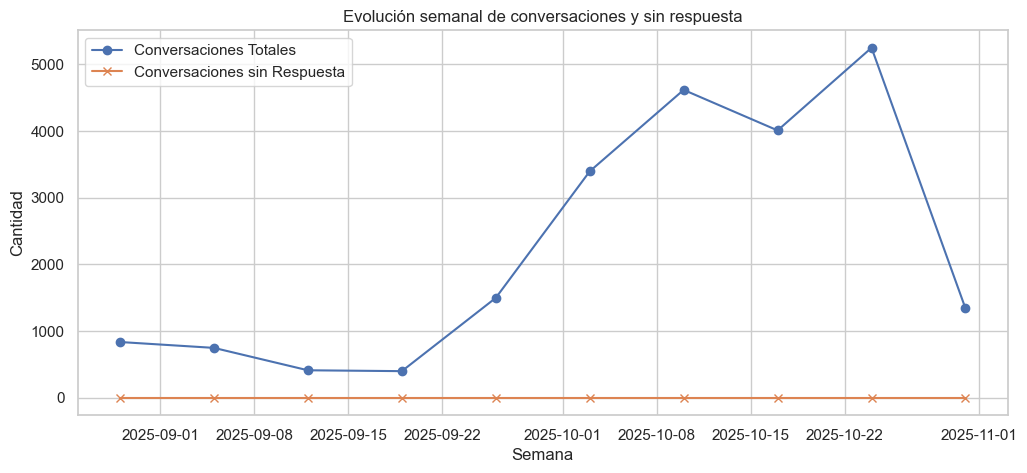

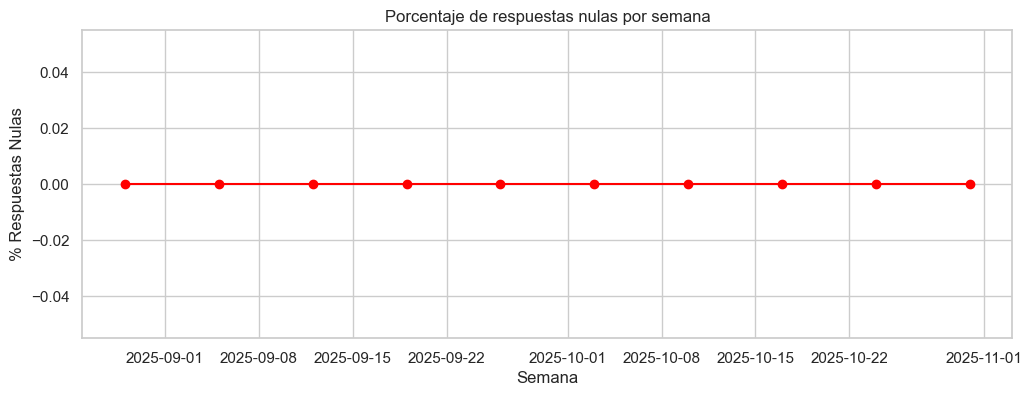


Promedio semanal de conversaciones totales: 2250.7
Promedio semanal de respuestas nulas: 0.0
Promedio semanal de % respuestas nulas: 0.0


In [ ]:
import matplotlib.pyplot as plt

# Resumen estadístico general
print("Resumen estadístico general:")
display(gr_cifras_conversaciones[orden_salida].describe())

# Semanas con mayor cantidad de respuestas nulas (problemas)
top_nulas = gr_cifras_conversaciones.sort_values("respuestas_nulas", ascending=False).head(3)
print("\nSemanas con más respuestas nulas:")
display(top_nulas[["respuestas_nulas"]])

# Semanas con mayor porcentaje de respuestas nulas
top_pct_nulas = gr_cifras_conversaciones.sort_values("pct_respuestas_nulas", ascending=False).head(3)
print("\nSemanas con mayor % de respuestas nulas:")
display(top_pct_nulas[["pct_respuestas_nulas"]])

# Evolución semanal de conversaciones y problemas
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(gr_cifras_conversaciones.index, gr_cifras_conversaciones["conversaciones_totales"], label="Conversaciones Totales", marker='o')
ax1.plot(gr_cifras_conversaciones.index, gr_cifras_conversaciones["conversaciones_sin_rta"], label="Conversaciones sin Respuesta", marker='x')
ax1.set_ylabel("Cantidad")
ax1.set_xlabel("Semana")
ax1.legend()
plt.title("Evolución semanal de conversaciones y sin respuesta")
plt.show()

# Evolución del % de respuestas nulas
plt.figure(figsize=(12,4))
plt.plot(gr_cifras_conversaciones.index, gr_cifras_conversaciones["pct_respuestas_nulas"], marker='o', color='red')
plt.ylabel("% Respuestas Nulas")
plt.xlabel("Semana")
plt.title("Porcentaje de respuestas nulas por semana")
plt.grid(True)
plt.show()

# Resumen de promedios
print("\nPromedio semanal de conversaciones totales:", gr_cifras_conversaciones["conversaciones_totales"].mean())
print("Promedio semanal de respuestas nulas:", gr_cifras_conversaciones["respuestas_nulas"].mean())
print("Promedio semanal de % respuestas nulas:", gr_cifras_conversaciones["pct_respuestas_nulas"].mean())

In [ ]:
total_registros = len(df_merged_final)
registros_no_nulos = df_merged_final['respuesta'].notna().sum()
porcentaje_filtrados = (total_registros - registros_no_nulos) / total_registros * 100 if total_registros else 0

print(f"Registros totales antes de filtrar: {total_registros}")
print(f"Registros con respuesta no nula: {registros_no_nulos}")
print(f"Porcentaje de registros filtrados (respuesta nula): {porcentaje_filtrados:.2f}%")

df_merged_final = df_merged_final[~df_merged_final.respuesta.isna()]

# Análisis por conversación: ¿Cuántas conversaciones pierden todos sus registros por filtrado?
convs_totales = df_merged_final['fk_tbl_conversaciones_conecta2'].nunique()
convs_antes = df_merged_1['fk_tbl_conversaciones_conecta2'].nunique() if 'df_merged_1' in locals() else None

if convs_antes is not None:
    print(f"Conversaciones únicas antes de filtrar: {convs_antes}")
    print(f"Conversaciones únicas después de filtrar: {convs_totales}")
    print(f"Porcentaje de conversaciones eliminadas: {((convs_antes - convs_totales) / convs_antes * 100):.2f}%")
else:
    print(f"Conversaciones únicas después de filtrar: {convs_totales}")

Registros totales antes de filtrar: 38870
Registros con respuesta no nula: 38870
Porcentaje de registros filtrados (respuesta nula): 0.00%
Conversaciones únicas antes de filtrar: 23986
Conversaciones únicas después de filtrar: 22507
Porcentaje de conversaciones eliminadas: 6.17%


### RESPUESTAS VÁLIDAS

In [140]:
# Crea la máscara una sola vez
mask = df_merged_final.fk_tbl_conversaciones_conecta2.isin(conecta_2_evaluados.conversation_id.unique())

df_nuevos = df_merged_final[~mask]
df_merged_final = df_merged_final[mask]

In [ ]:
---

## 5. CLASIFICACIÓN CON IA (GEMINI)

Utilizamos Gemini para clasificar automáticamente las conversaciones en categorías según la calidad de la interacción.

### 4.2 Análisis Detallado de Factores que Generan Respuestas NULL

Investigamos **cuándo** y **por qué** Conecta no logra responder:
- Patrones por hora del día
- Patrones por día de la semana  
- Impacto de carga concurrente del sistema
- Evolución temporal

In [ ]:
# Preparar datos para análisis de NULL responses
df_null_analysis = df_merged_final.copy()

# Asegurar que fecha_hora_inicio es datetime
df_null_analysis['fecha_hora_inicio'] = pd.to_datetime(df_null_analysis['fecha_hora_inicio'])

# Crear features temporales
df_null_analysis['hour'] = df_null_analysis['fecha_hora_inicio'].dt.hour
df_null_analysis['day_of_week'] = df_null_analysis['fecha_hora_inicio'].dt.day_name()
df_null_analysis['date'] = df_null_analysis['fecha_hora_inicio'].dt.date
df_null_analysis['is_null_response'] = df_null_analysis['respuesta'].isna()

# Calcular conversaciones concurrentes (por hora)
df_null_analysis['datetime_hour'] = df_null_analysis['fecha_hora_inicio'].dt.floor('h')
concurrent_convs = df_null_analysis.groupby('datetime_hour')['fk_tbl_conversaciones_conecta2'].nunique().reset_index()
concurrent_convs.columns = ['datetime_hour', 'concurrent_conversations']
df_null_analysis = df_null_analysis.merge(concurrent_convs, on='datetime_hour', how='left')

print("✓ Datos preparados para análisis de NULL responses")

In [ ]:
# ===== ANÁLISIS POR HORA DEL DÍA =====
print("="*80)
print("ANÁLISIS DE RESPUESTAS NULL/NA POR HORA DEL DÍA")
print("="*80)

hourly_analysis = df_null_analysis.groupby('hour').agg({
    'is_null_response': ['sum', 'count', 'mean']
}).reset_index()
hourly_analysis.columns = ['hour', 'null_count', 'total_questions', 'null_rate']
hourly_analysis['null_pct'] = hourly_analysis['null_rate'] * 100
hourly_analysis = hourly_analysis.sort_values('null_pct', ascending=False)

print("\nTop 10 horas con mayor tasa de respuestas NULL:")
print(hourly_analysis.head(10)[['hour', 'null_count', 'total_questions', 'null_pct']].to_string(index=False))

# Visualización
plt.figure(figsize=(14, 5))
hourly_sorted = hourly_analysis.sort_values('hour')
plt.bar(hourly_sorted['hour'], hourly_sorted['null_pct'], color='steelblue', alpha=0.7)
overall_null_rate = df_null_analysis['is_null_response'].mean() * 100
plt.axhline(y=overall_null_rate, color='red', linestyle='--', 
            label=f'Promedio general ({overall_null_rate:.2f}%)')
plt.xlabel('Hora del día')
plt.ylabel('% Respuestas NULL')
plt.title('Tasa de Respuestas NULL por Hora del Día')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ===== ANÁLISIS POR DÍA DE LA SEMANA =====
print("="*80)
print("ANÁLISIS DE RESPUESTAS NULL/NA POR DÍA DE LA SEMANA")
print("="*80)

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_analysis = df_null_analysis.groupby('day_of_week').agg({
    'is_null_response': ['sum', 'count', 'mean']
}).reset_index()
daily_analysis.columns = ['day_of_week', 'null_count', 'total_questions', 'null_rate']
daily_analysis['null_pct'] = daily_analysis['null_rate'] * 100
daily_analysis['day_order'] = daily_analysis['day_of_week'].map({day: i for i, day in enumerate(day_order)})
daily_analysis = daily_analysis.sort_values('day_order')

print(daily_analysis[['day_of_week', 'null_count', 'total_questions', 'null_pct']].to_string(index=False))

# Visualización
plt.figure(figsize=(12, 5))
plt.bar(daily_analysis['day_of_week'], daily_analysis['null_pct'], color='coral', alpha=0.7)
plt.axhline(y=overall_null_rate, color='red', linestyle='--', 
            label=f'Promedio general ({overall_null_rate:.2f}%)')
plt.xlabel('Día de la semana')
plt.ylabel('% Respuestas NULL')
plt.title('Tasa de Respuestas NULL por Día de la Semana')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ===== ANÁLISIS POR CARGA CONCURRENTE =====
print("="*80)
print("ANÁLISIS DE RESPUESTAS NULL/NA POR CARGA CONCURRENTE")
print("="*80)

# Crear bins de conversaciones concurrentes
df_null_analysis['concurrent_bin'] = pd.cut(
    df_null_analysis['concurrent_conversations'],
    bins=[0, 5, 10, 20, 50, 100, 1000],
    labels=['1-5', '6-10', '11-20', '21-50', '51-100', '100+']
)

concurrent_analysis = df_null_analysis.groupby('concurrent_bin', observed=False).agg({
    'is_null_response': ['sum', 'count', 'mean']
}).reset_index()
concurrent_analysis.columns = ['concurrent_range', 'null_count', 'total_questions', 'null_rate']
concurrent_analysis['null_pct'] = concurrent_analysis['null_rate'] * 100

print(concurrent_analysis[['concurrent_range', 'null_count', 'total_questions', 'null_pct']].to_string(index=False))

# Identificar el problema crítico
high_load_row = concurrent_analysis[concurrent_analysis['concurrent_range'] == '21-50']
if len(high_load_row) > 0 and high_load_row.iloc[0]['null_pct'] > overall_null_rate * 1.5:
    print("\n⚠️  HALLAZGO CRÍTICO:")
    print(f"   Cuando hay 21-50 conversaciones concurrentes, la tasa de NULL es {high_load_row.iloc[0]['null_pct']:.2f}%")
    print(f"   Esto es {high_load_row.iloc[0]['null_pct'] / overall_null_rate:.1f}x el promedio general!")
    print(f"   Posible problema de capacidad del sistema bajo carga moderada-alta.")

# Visualización
plt.figure(figsize=(12, 5))
colors = ['green' if x < 5 else 'orange' if x < 10 else 'red' for x in concurrent_analysis['null_pct']]
plt.bar(concurrent_analysis['concurrent_range'], concurrent_analysis['null_pct'], 
        color=colors, alpha=0.7)
plt.axhline(y=overall_null_rate, color='blue', linestyle='--', 
            label=f'Promedio general ({overall_null_rate:.2f}%)')
plt.xlabel('Conversaciones Concurrentes')
plt.ylabel('% Respuestas NULL')
plt.title('Tasa de Respuestas NULL por Carga Concurrente')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ===== TENDENCIA TEMPORAL =====
print("="*80)
print("TENDENCIA DE RESPUESTAS NULL/NA EN EL TIEMPO")
print("="*80)

date_trend = df_null_analysis.groupby('date').agg({
    'is_null_response': ['sum', 'count', 'mean']
}).reset_index()
date_trend.columns = ['date', 'null_count', 'total_questions', 'null_rate']
date_trend['null_pct'] = date_trend['null_rate'] * 100
date_trend = date_trend.sort_values('date')

# Últimos 30 días
print("\nÚltimos 30 días:")
print(date_trend.tail(30).to_string(index=False))

# Encontrar el peor día
worst_day = date_trend.loc[date_trend['null_pct'].idxmax()]
print(f"\n📉 Peor día: {worst_day['date']} con {worst_day['null_pct']:.2f}% de respuestas NULL")
print(f"   Total preguntas ese día: {int(worst_day['total_questions'])}")

# Visualización
plt.figure(figsize=(16, 5))
plt.plot(date_trend['date'], date_trend['null_pct'], marker='o', 
         linewidth=2, markersize=4, color='darkblue')
plt.axhline(y=overall_null_rate, color='red', linestyle='--', 
            label=f'Promedio general ({overall_null_rate:.2f}%)')
plt.xlabel('Fecha')
plt.ylabel('% Respuestas NULL')
plt.title('Tendencia de Respuestas NULL en el Tiempo')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Guardar análisis
df_null_analysis.to_csv('../Salidas/null_response_detailed_analysis.csv', index=False)
print("\n✓ Análisis detallado guardado en '../Salidas/null_response_detailed_analysis.csv'")

In [ ]:
# ===== RESUMEN EJECUTIVO DE HALLAZGOS =====
print("\n" + "="*80)
print("RESUMEN EJECUTIVO - ANÁLISIS DE RESPUESTAS NULL")
print("="*80)

total_questions = len(df_null_analysis)
null_count = df_null_analysis['is_null_response'].sum()
null_pct = (null_count / total_questions) * 100

print(f"\n📊 ESTADÍSTICAS GENERALES:")
print(f"   Total de preguntas: {total_questions:,}")
print(f"   Respuestas NULL: {null_count:,} ({null_pct:.2f}%)")
print(f"   Respuestas válidas: {total_questions - null_count:,} ({100-null_pct:.2f}%)")

print(f"\n🕐 PATRONES TEMPORALES:")
peak_hour = hourly_analysis.loc[hourly_analysis['null_pct'].idxmax()]
print(f"   Hora pico de NULLs: {int(peak_hour['hour'])}:00 ({peak_hour['null_pct']:.2f}%)")

peak_day = daily_analysis.loc[daily_analysis['null_pct'].idxmax()]
print(f"   Día pico de NULLs: {peak_day['day_of_week']} ({peak_day['null_pct']:.2f}%)")

print(f"\n⚙️  IMPACTO DE CARGA:")
for _, row in concurrent_analysis.iterrows():
    if row['null_pct'] > overall_null_rate * 1.5:
        print(f"   ⚠️  {row['concurrent_range']} conversaciones: {row['null_pct']:.2f}% NULL " +
              f"({row['null_pct']/overall_null_rate:.1f}x promedio)")

print(f"\n📅 TENDENCIA:")
recent_trend = date_trend.tail(7)['null_pct'].mean()
older_trend = date_trend.head(7)['null_pct'].mean() if len(date_trend) >= 14 else None
if older_trend:
    trend_direction = "📈 Aumentando" if recent_trend > older_trend else "📉 Disminuyendo"
    print(f"   {trend_direction}: Últimos 7 días: {recent_trend:.2f}% vs Primeros 7 días: {older_trend:.2f}%")
else:
    print(f"   Últimos 7 días promedio: {recent_trend:.2f}%")

print("\n" + "="*80)

### 4.3 Relación entre Longitud de Pregunta y Respuestas NULL

**Hipótesis**: ¿Las preguntas muy cortas (≤3 palabras) tienen mayor probabilidad de recibir respuestas nulas?

Evaluamos si existe correlación entre la brevedad de la pregunta y la capacidad de Conecta para responder.

In [ ]:
# ===== ANÁLISIS DE PREGUNTAS CORTAS =====
print("="*80)
print("ANÁLISIS: LONGITUD DE PREGUNTA vs RESPUESTAS NULL")
print("="*80)

# Crear análisis de longitud de pregunta
df_question_length = df_null_analysis.copy()

# Contar palabras en cada pregunta
df_question_length['word_count'] = df_question_length['pregunta'].str.split().str.len()
df_question_length['pregunta_length_chars'] = df_question_length['pregunta'].str.len()

# Categorizar preguntas
df_question_length['question_category'] = pd.cut(
    df_question_length['word_count'],
    bins=[0, 3, 5, 10, 20, 1000],
    labels=['≤3 palabras', '4-5 palabras', '6-10 palabras', '11-20 palabras', '>20 palabras']
)

# Análisis por categoría
print("\n📊 DISTRIBUCIÓN DE PREGUNTAS POR LONGITUD:")
print("-"*80)
category_analysis = df_question_length.groupby('question_category', observed=False).agg({
    'is_null_response': ['sum', 'count', 'mean']
}).reset_index()
category_analysis.columns = ['category', 'null_count', 'total_questions', 'null_rate']
category_analysis['null_pct'] = category_analysis['null_rate'] * 100

print(category_analysis[['category', 'null_count', 'total_questions', 'null_pct']].to_string(index=False))

# Análisis específico de ≤3 palabras
print("\n" + "="*80)
print("HALLAZGO CLAVE: PREGUNTAS ≤3 PALABRAS")
print("="*80)

short_questions = df_question_length[df_question_length['word_count'] <= 3]
other_questions = df_question_length[df_question_length['word_count'] > 3]

short_null_rate = short_questions['is_null_response'].mean() * 100
other_null_rate = other_questions['is_null_response'].mean() * 100

print(f"\nPreguntas ≤3 palabras:")
print(f"  Total: {len(short_questions):,} ({len(short_questions)/len(df_question_length)*100:.1f}% del total)")
print(f"  Respuestas NULL: {short_questions['is_null_response'].sum():,}")
print(f"  Tasa NULL: {short_null_rate:.2f}%")

print(f"\nPreguntas >3 palabras:")
print(f"  Total: {len(other_questions):,} ({len(other_questions)/len(df_question_length)*100:.1f}% del total)")
print(f"  Respuestas NULL: {other_questions['is_null_response'].sum():,}")
print(f"  Tasa NULL: {other_null_rate:.2f}%")

# Comparación
diff = short_null_rate - other_null_rate
if diff > 0:
    print(f"\n⚠️  Las preguntas ≤3 palabras tienen {diff:.2f}% MÁS NULLs que preguntas más largas")
    print(f"   Ratio: {short_null_rate/other_null_rate:.2f}x más probable recibir NULL")
else:
    print(f"\n✓ Las preguntas ≤3 palabras tienen {abs(diff):.2f}% MENOS NULLs que preguntas más largas")

# Muestras de preguntas cortas
print("\n📝 EJEMPLOS DE PREGUNTAS ≤3 PALABRAS:")
print("-"*80)
short_sample = short_questions[short_questions['pregunta'].notna()].sample(min(10, len(short_questions)))
for idx, row in short_sample.iterrows():
    word_count = row['word_count']
    has_null = "❌ NULL" if row['is_null_response'] else "✓ Respondida"
    print(f"  [{word_count} palabras] '{row['pregunta']}' → {has_null}")

# Statistical significance test (Chi-square)
from scipy.stats import chi2_contingency

# Create contingency table
contingency = pd.crosstab(
    df_question_length['word_count'] <= 3,
    df_question_length['is_null_response']
)
chi2, p_value, dof, expected = chi2_contingency(contingency)

print(f"\n📈 SIGNIFICANCIA ESTADÍSTICA:")
print(f"  Chi-cuadrado: {chi2:.2f}")
print(f"  P-value: {p_value:.6f}")
if p_value < 0.05:
    print(f"  ✓ La correlación es ESTADÍSTICAMENTE SIGNIFICATIVA (p < 0.05)")
else:
    print(f"  ⚠️  La correlación NO es estadísticamente significativa (p >= 0.05)")

print("\n" + "="*80)

In [ ]:
# ===== VISUALIZACIÓN: LONGITUD DE PREGUNTA vs NULL RATE =====

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico 1: Por categoría
ax = axes[0]
category_analysis_sorted = category_analysis.sort_values('null_pct', ascending=False)
colors = ['red' if cat == '≤3 palabras' else 'steelblue' for cat in category_analysis_sorted['category']]
ax.bar(category_analysis_sorted['category'], category_analysis_sorted['null_pct'], 
       color=colors, alpha=0.7)
ax.axhline(y=overall_null_rate, color='darkred', linestyle='--', 
           label=f'Promedio general ({overall_null_rate:.2f}%)')
ax.set_xlabel('Categoría de Pregunta')
ax.set_ylabel('% Respuestas NULL')
ax.set_title('Tasa de NULL por Longitud de Pregunta')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Gráfico 2: Distribución de palabras (scatter)
ax = axes[1]
# Agrupar por word_count
word_analysis = df_question_length.groupby('word_count').agg({
    'is_null_response': ['mean', 'count']
}).reset_index()
word_analysis.columns = ['word_count', 'null_rate', 'count']
word_analysis['null_pct'] = word_analysis['null_rate'] * 100

# Filtrar solo hasta 20 palabras para mejor visualización
word_analysis_viz = word_analysis[word_analysis['word_count'] <= 20]

ax.scatter(word_analysis_viz['word_count'], word_analysis_viz['null_pct'], 
           s=word_analysis_viz['count']/10, alpha=0.6, color='steelblue')
ax.axhline(y=overall_null_rate, color='darkred', linestyle='--', 
           label=f'Promedio general ({overall_null_rate:.2f}%)')
ax.axvline(x=3, color='orange', linestyle=':', linewidth=2, label='Umbral 3 palabras')
ax.set_xlabel('Número de Palabras en Pregunta')
ax.set_ylabel('% Respuestas NULL')
ax.set_title('NULL Rate por Número Exacto de Palabras\n(Tamaño = # de preguntas)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Visualizaciones generadas")

In [142]:
try:
    from dotenv import load_dotenv
    load_dotenv()
    print('Variables de entorno cargadas desde .env (si existía).')
except ModuleNotFoundError:
    print('python-dotenv no está instalado; continúa sin cargar archivo .env.')

api_key = os.getenv('GOOGLE_API_KEY')
if not api_key:
    raise RuntimeError('Configura la variable de entorno GEMINI_API_KEY antes de continuar.')

import google.generativeai as genai
from google.api_core import exceptions

genai.configure(api_key=api_key)
MODEL_ID = 'gemini-2.5-flash'
model = genai.GenerativeModel(MODEL_ID)

Variables de entorno cargadas desde .env (si existía).


In [143]:
SYSTEM_PROMPT = """Eres analista de control de calidad del asistente virtual de Banco Davivienda.

Tu tarea es etiquetar la siguiente interacción en EXACTAMENTE una de las siguientes categorías.
Las categorías permitidas son: 'Pregunta valida', 'Sin información', 'Pregunta no valida', o 'Solicitud Paso Experto'.

Reglas de Etiquetado:
1. 'Pregunta valida': la consulta del usuario está relacionada con productos bancarios, procesos de Davivienda, O temas OPERACIONALES relevantes para Davivienda y la respuesta del bot es pertinente y útil. 
2. 'Sin información': La respuesta del bot indica explicitamente que NO tiene información (p. ej., "Lo siento, no encontré..."). Priorizar esta sobre 'Pregunta valida'.
3. 'Pregunta no valida': la consulta es ambigua o NO está relacionada con el contexto bancario o OPERACIONAL DE Davivienda (ej: clima, política), o el enunciado está vacío/incompleto. 
4. 'Solicitud Paso Experto': Petición directa de hablar con un asesor, humano o ejecutivo.

Devuelve JSON con las claves:
- conversation_id (número entero de la conversación).
- category (una de las categorías válidas).
- rationale (breve explicación en español sobre la decisión).

Instrucciones adicionales:
- Prioriza 'Sin información' cuando el bot exprese que no tiene datos, incluso si la pregunta fue válida.
- Etiqueta como 'Solicitud Paso Experto' cualquier petición directa de escalar a un humano aunque la respuesta no lo conceda.
- Usa 'Pregunta no valida' si la pregunta está vacía, contiene caracteres irrelevantes o trata temas ajenos al contexto operativo de Davivienda.
- En los demás casos utiliza 'Pregunta valida' siempre que la respuesta responda a la pregunta.

IMPORTANTE: TU RESPUESTA DEBE SER ÚNICAMENTE EL OBJETO JSON COMPLETO. 
NO AÑADAS NINGÚN BLOQUE DE CÓDIGO (NO USES ```JSON) NI TEXTO EXPLICATIVO."""

VALID_CATEGORIES = {
    'Pregunta valida', 'Sin información', 'Pregunta no valida', 'Solicitud Paso Experto',
}

CATEGORY_ALIASES = {
    'pregunta válida': 'Pregunta valida', 'pregunta valida': 'Pregunta valida', 
    'pregunta no válida': 'Pregunta no valida', 'sin informacion': 'Sin información', 
    'sin información': 'Sin información', 'solicitud paso experto': 'Solicitud Paso Experto',
}


def safe_strip(val):
    if pd.isna(val):
        return ''
    return str(val).strip()

def build_prompt(row):
    conversation_id = int(row.get('fk_tbl_conversaciones_conecta2'))
    pregunta = safe_strip(row.get('pregunta'))
    respuesta = safe_strip(row.get('respuesta'))
    if not pregunta:
        pregunta = '[pregunta vacía]'
    if not respuesta:
        respuesta = '[respuesta vacía]'
    return (
        f"{SYSTEM_PROMPT}\n\n"
        f"ID conversacion: {conversation_id}\n"
        f"Pregunta del usuario: {pregunta}\n"
        f"Respuesta del agente: {respuesta}\n\n"
        'Devuelve solo el JSON requerido.'
    )
    
def parse_gemini_json(text):
    cleaned = text.strip()
    if cleaned.startswith('```'):
        cleaned = cleaned[3:]
        cleaned = cleaned.lstrip()
        if cleaned.lower().startswith('json'):
            cleaned = cleaned[4:].lstrip()
        if cleaned.endswith('```'):
            cleaned = cleaned[:-3]
    if cleaned.lower().startswith('json'):
        cleaned = cleaned[4:].lstrip()
    return json.loads(cleaned)

def classify_with_gemini(row, max_retries=3, base_sleep_seconds=2.0, quota_cooldown_seconds=45):
    prompt = ''.join(build_prompt(row))
    last_error = None
    for attempt in range(max_retries):
        try:
            response = model.generate_content(prompt)
        except exceptions.ResourceExhausted as exc:
            wait_time = max(quota_cooldown_seconds, base_sleep_seconds * (attempt + 1) * 5)
            print(f'Límite de cuota alcanzado; esperando {wait_time:.0f}s antes de reintentar...')
            time.sleep(wait_time)
            last_error = exc
            continue
        except exceptions.GoogleAPICallError as exc:
            wait_time = base_sleep_seconds * (attempt + 1)
            print(f'Error de la API ({exc.__class__.__name__}); reintentando en {wait_time:.1f}s...')
            time.sleep(wait_time)
            last_error = exc
            continue

        candidate_text = ''
        if response.candidates:
            first_candidate = response.candidates[0]
            for part in first_candidate.content.parts:
                if getattr(part, 'text', None):
                    candidate_text += part.text
        candidate_text = candidate_text.strip()
        if not candidate_text:
            last_error = ValueError('Respuesta sin texto interpretable del modelo.')
            wait_time = base_sleep_seconds * (attempt + 1)
            print(f'Sin texto interpretable; reintentando en {wait_time:.1f}s...')
            time.sleep(wait_time)
            continue
        try:
            parsed = parse_gemini_json(candidate_text)
            category_raw = (parsed.get('category') or '').strip()
            category = CATEGORY_ALIASES.get(category_raw.lower(), category_raw)
            if category not in VALID_CATEGORIES:
                raise KeyError(f'Categoría no válida recibida: {category_raw}')
            return {
                'conversation_id': int(parsed.get('conversation_id', row.get('fk_tbl_conversaciones_conecta2'))),
                'category': category,
                'rationale': (parsed.get('rationale') or '').strip(),
            }
        except (json.JSONDecodeError, KeyError, AttributeError) as exc:
            last_error = exc
            wait_time = base_sleep_seconds * (attempt + 1)
            print(f'Error interpretando respuesta (intento {attempt + 1}/{max_retries}): {exc}. Reintentando en {wait_time:.1f}s...')
            time.sleep(wait_time)
    raise ValueError(f'No se pudo interpretar la respuesta de Gemini tras {max_retries} intentos. Último error: {last_error}')

In [144]:
# MAX_INTERACTIONS = None  # Cambia a None para clasificar todo el dataset (incrementa el costo).
# subset = df_nuevos if MAX_INTERACTIONS is None else df_nuevos.head(MAX_INTERACTIONS)

# print(f'Clasificando {subset.shape[0]} interacciones...')

# resultados = []
# for index, row in enumerate(subset.to_dict(orient='records'), start=1):
#     resultado = classify_with_gemini(row)
#     resultados.append(resultado)
#     if index % 25 == 0:
#         print(f'{index} interacciones clasificadas...')

# clasificacion = pd.DataFrame(resultados)

In [145]:
# resultados_previos_cop = resultados_previos

In [146]:
from concurrent.futures import ThreadPoolExecutor

# Obtén los IDs ya evaluados en resultados
ids_ya_analizados = conecta_2_evaluados.conversation_id.unique()

# Si existe resultados_paralelo_parcial.csv, excluye también esos IDs
if os.path.exists('resultados_paralelo_parcial.csv'):
    resultados_previos = pd.read_csv('resultados_paralelo_parcial.csv')
    ids_ya_procesados = set(resultados_previos['conversation_id'])
    print(f"Ya procesados previamente: {len(ids_ya_procesados)}")
else:
    ids_ya_procesados = set()

# Filtra las filas pendientes en df_nuevos
pendientes = df_nuevos[
    ~df_nuevos['fk_tbl_conversaciones_conecta2'].isin(ids_ya_analizados)
    & ~df_nuevos['fk_tbl_conversaciones_conecta2'].isin(ids_ya_procesados)
]

print(f"Pendientes por evaluar: {len(pendientes)}")

Ya procesados previamente: 1392
Pendientes por evaluar: 5237


In [182]:
import os
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# --- IDs ya evaluados ---
ids_ya_analizados = set(conecta_2_evaluados.conversation_id.unique())

# --- Excluir ya procesados si existe archivo parcial ---
if os.path.exists('resultados_paralelo_parcial.csv'):
    resultados_previos = pd.read_csv('resultados_paralelo_parcial.csv')
    ids_ya_procesados = set(resultados_previos['conversation_id'])
    print(f"Ya procesados previamente: {len(ids_ya_procesados)}")
else:
    resultados_previos = pd.DataFrame()
    ids_ya_procesados = set()

# --- Filtra los pendientes para excluir los ya evaluados y procesados ---
pendientes = df_nuevos[
    ~df_nuevos['fk_tbl_conversaciones_conecta2'].isin(ids_ya_analizados)
    & ~df_nuevos['fk_tbl_conversaciones_conecta2'].isin(ids_ya_procesados)
]
print(f"Pendientes por analizar tras excluir previos: {len(pendientes)}")

# --- Funciones de procesamiento ---
def split_dataframe(df, n):
    return np.array_split(df, n)

def process_rows(rows, subset_idx=None):
    print(f"Subset {subset_idx} iniciado con {len(rows)} filas")
    resultados = []
    for row in tqdm(rows.to_dict(orient='records'), desc=f"Subset {subset_idx}", position=subset_idx):
        resultados.append(classify_with_gemini(row))
    return resultados

num_workers = 4  # Ajusta según tu CPU y cuota API
subsets = split_dataframe(pendientes, num_workers)

# --- Mantén los resultados previos y agrega solo los nuevos ---
resultados_paralelo = resultados_previos.to_dict(orient='records') if not resultados_previos.empty else []

with ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = [
        executor.submit(process_rows, subset, idx)
        for idx, subset in enumerate(subsets)
    ]
    for i, future in enumerate(futures, 1):
        subset_result = future.result()
        resultados_paralelo.extend(subset_result)
        # Guarda incrementalmente, sin perder los previos
        pd.DataFrame(resultados_paralelo).to_csv('resultados_paralelo_parcial.csv', index=False)
        print(f"Guardado parcial tras subset {i}: {len(resultados_paralelo)} filas")

# resultados_paralelo contiene todos los resultados nuevos y previos

clasificacion_total_parcial = pd.DataFrame(resultados_paralelo)
clasificacion_total_parcial.to_csv('resultados_clasificacion_total_parcial.csv', index=False)

c:\Users\gabrieva\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Ya procesados previamente: 1392
Pendientes por analizar tras excluir previos: 5237
Subset 0 iniciado con 1310 filas
Subset 1 iniciado con 1309 filas
Subset 2 iniciado con 1309 filas
Subset 3 iniciado con 1309 filas


Subset 0:   0%|          | 0/1310 [00:00<?, ?it/s]


Subset 0:   0%|          | 1/1310 [00:04<1:29:17,  4.09s/it]


Subset 0:   0%|          | 2/1310 [00:07<1:19:13,  3.63s/it]




Subset 0:   0%|          | 3/1310 [00:11<1:19:17,  3.64s/it]


Subset 0:   0%|          | 5/1310 [00:17<1:09:17,  3.19s/it]

Subset 0:   0%|          | 6/1310 [00:20<1:08:51,  3.17s/it]


Subset 0:   1%|          | 7/1310 [00:25<1:21:19,  3.75s/it]




Subset 0:   1%|          | 8/1310 [00:29<1:22:10,  3.79s/it]



Subset 0:   1%|          | 9/1310 [00:36<1:45:03,  4.84s/it]


Subset 0:   1%|          | 11/1310 [00:41<1:18:12,  3.61s/it]

Subset 0:   1%|          | 12/1310 [00:44<1:14:57,  3.46s/it]


Subset 0:   1%|          | 14/1310 [00:49<1:04:20,  2.98s/it]






Subset 0:   1%|          | 16/1310 [01:00<1:27:14,  4.05s/it]


Subset 0:   1%|▏         | 17/1310 [01:04<1:24:18,  3.91s/it]


Subset 0:   1%|▏         | 18/1310 [01:06<1:11:16,  3.31s/it]


Subset 0:   1%|▏         | 19/1310 [01:10<1:15:55,  

Guardado parcial tras subset 1: 3570 filas












































































Subset 1: 100%|██████████| 1309/1309 [1:36:54<00:00,  4.44s/it]


Guardado parcial tras subset 2: 4879 filas
Guardado parcial tras subset 3: 6188 filas


























































































Subset 3: 100%|██████████| 1309/1309 [1:39:17<00:00,  4.55s/it]


Guardado parcial tras subset 4: 7497 filas


In [183]:
df_nuevos_cop = df_nuevos.copy()
clasificacion_total = pd.DataFrame(resultados_paralelo) 

In [184]:
clasificacion_total = clasificacion_total[["conversation_id", "category", "rationale"]]

In [185]:
# El cumcount debe numerar las interacciones dentro de cada conversación
missing_mask = ~df_nuevos_cop['fk_tbl_conversaciones_conecta2'].isin(clasificacion_total['conversation_id'])
if missing_mask.any():
    df_defaults = (
        df_nuevos_cop.loc[missing_mask, ['fk_tbl_conversaciones_conecta2']]
        .rename(columns={'fk_tbl_conversaciones_conecta2': 'conversation_id'})
    )
    df_defaults['category'] = 'Pregunta valida'
    df_defaults['rationale'] = 'Pregunta generica'
    clasificacion_total = pd.concat([clasificacion_total, df_defaults], ignore_index=True)

clasificacion_total['merge_idx'] = clasificacion_total.groupby('conversation_id').cumcount()
df_nuevos_cop['merge_idx'] = df_nuevos_cop.groupby('fk_tbl_conversaciones_conecta2').cumcount()

auditoria = clasificacion_total.merge(
    df_nuevos_cop[['fk_tbl_conversaciones_conecta2', 'fecha_hora_inicio','pregunta', 'respuesta', 'flg_experto', 'motivo_experto', 'REGIONAL','merge_idx', 'calificacion_pregunta_1', 'calificacion_pregunta_2', 'correo']],
    left_on=['conversation_id', 'merge_idx'],
    right_on=['fk_tbl_conversaciones_conecta2', 'merge_idx'],
    how='left'
)

auditoria['fecha'] = pd.to_datetime(auditoria['fecha_hora_inicio']).dt.date
auditoria["fecha_hora_inicio"] = pd.to_datetime(auditoria["fecha_hora_inicio"])
auditoria["fecha"] = auditoria["fecha_hora_inicio"].dt.date

# cols = ['conversation_id', 'category', 'rationale', 'pregunta', 'respuesta', 'flg_experto']
# auditoria.head()

In [186]:
def clasificacion_no_gestionada(group):
    categorias = group['category'].astype(str).str.strip().str.lower()
    # 1. Preguntas temas no bancarios: al menos una 'pregunta no valida' y ninguna 'sin información'
    if (categorias == 'pregunta no valida').any() and not (categorias == 'sin información').any():
        return 'Preguntas temas no bancarios'
    # 2. Al menos una 'sin información'
    if (categorias == 'sin información').any():
        return 'Sin información'
    # 3. Al menos una 'solicitud paso experto' y ninguna 'sin información'
    if (categorias == 'solicitud paso experto').any() and not (categorias == 'sin información').any():
        return 'Usuario solicitó paso a experto'
    # Si no cumple ninguna, es mezcla de categorías no contemplada
    return 'Otro'

def clasificacion_principal(group):
    categorias_no_gestionada = {'Sin información', 'Solicitud Paso Experto', 'Pregunta no valida'}
    if any(group['category'].isin(categorias_no_gestionada)):
        return 'No Gestionada Conecta'
    else:
        return 'Gestionada Conecta'

def clasificacion_gestionada(group):
    if group['motivo_experto'].isna().all():
        return 'Conecta Retuvo'
    if group['motivo_experto'].notna().any():
        return 'Ofreció PE'
    return 'Otro'


In [37]:
resultados = resultados_paralelo

In [187]:
auditoria.fecha = pd.to_datetime(auditoria.fecha)

In [188]:
for cid, group in auditoria.groupby('conversation_id'):
    grupo_principal = clasificacion_principal(group)
    motivo_experto_flag = int(group['motivo_experto'].notna().any())
    flg_experto_flag = int((group['flg_experto'] == 1).any())

    motivos = group['motivo_experto'].dropna().unique()
    motivo_experto_unicos = motivos[0] if len(motivos) > 0 else None
    regional = group['REGIONAL'].dropna().iloc[0] if group['REGIONAL'].notna().any() else None
    calif1_mean = pd.to_numeric(group['calificacion_pregunta_1'], errors='coerce').mean()
    calif2_mean = pd.to_numeric(group['calificacion_pregunta_2'], errors='coerce').mean()
    fecha_conv = group['fecha'].min()
    filas_por_conversacion = len(group)
    correo = group['correo']

    if grupo_principal == 'No Gestionada Conecta':
        subgrupo = clasificacion_no_gestionada(group)
    else:
        subgrupo = clasificacion_gestionada(group)

    resultados.append({
        'conversation_id': cid,
        'grupo_principal': grupo_principal,
        'subgrupo': subgrupo,
        'flg_experto_flag': flg_experto_flag,
        'motivo_experto_flag': motivo_experto_flag,
        'motivo_experto_unicos': motivo_experto_unicos,
        'REGIONAL': regional,
        'calificacion_pregunta_1_mean': calif1_mean,
        'calificacion_pregunta_2_mean': calif2_mean,
        'fecha': fecha_conv,
        'filas_por_conversacion': filas_por_conversacion,
        'correo': correo
    })
    
df_resultados = pd.DataFrame(resultados)

# Filtra correctamente y haz copia para evitar el warning
no_gestionada = df_resultados[df_resultados['grupo_principal'] == 'No Gestionada Conecta'].copy()
ngc_convs = no_gestionada['conversation_id'].nunique()
no_gestionada.loc[:, 'percent_sobre_NGC'] = no_gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / ngc_convs * 100
no_gestionada.loc[:, 'percent_sobre_total'] = no_gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / df_resultados['conversation_id'].nunique() * 100

ngc_sub = no_gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_sum=('motivo_experto_flag', 'sum'),
    sobre_NGC=('percent_sobre_NGC', 'first'),
    sobre_total=('percent_sobre_total', 'first')
).reset_index()

for _, row in ngc_sub.iterrows():
    print(f"{row['subgrupo']}: {row['conversaciones']} conversaciones ({row['sobre_NGC']:.2f}% de NGC, {row['sobre_total']:.2f}% del total) | flg_experto==1: {row['flg_experto_sum']} | motivo_experto.notna(): {row['motivo_experto_sum']}")

print(f"\nSuma total motivo_experto.notna() en No Gestionada Conecta: {ngc_sub['motivo_experto_sum'].sum()}")

# Aplica igual para Gestionada Conecta
gestionada = df_resultados[df_resultados['grupo_principal'] == 'Gestionada Conecta'].copy()
gc_convs = gestionada['conversation_id'].nunique()
gestionada.loc[:, 'percent_sobre_GC'] = gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / gc_convs * 100
gestionada.loc[:, 'percent_sobre_total'] = gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / df_resultados['conversation_id'].nunique() * 100

gc_sub = gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_sum=('motivo_experto_flag', 'sum'),
    sobre_GC=('percent_sobre_GC', 'first'),
    sobre_total=('percent_sobre_total', 'first')
).reset_index()

for _, row in gc_sub.iterrows():
    print(f"{row['subgrupo']}: {row['conversaciones']} conversaciones ({row['sobre_GC']:.2f}% de GC, {row['sobre_total']:.2f}% del total) | flg_experto==1: {row['flg_experto_sum']} | motivo_experto.notna(): {row['motivo_experto_sum']}")

Preguntas temas no bancarios: 440 conversaciones (23.89% de NGC, 2.22% del total) | flg_experto==1: 61 | motivo_experto.notna(): 183
Sin información: 1152 conversaciones (62.54% de NGC, 5.82% del total) | flg_experto==1: 146 | motivo_experto.notna(): 491
Usuario solicitó paso a experto: 250 conversaciones (13.57% de NGC, 1.26% del total) | flg_experto==1: 125 | motivo_experto.notna(): 240

Suma total motivo_experto.notna() en No Gestionada Conecta: 914
Conecta Retuvo: 14737 conversaciones (79.25% de GC, 74.50% del total) | flg_experto==1: 0 | motivo_experto.notna(): 0
Ofreció PE: 3859 conversaciones (20.75% de GC, 19.51% del total) | flg_experto==1: 2039 | motivo_experto.notna(): 4601


In [189]:
# Agrupar por conversación y aplicar clasificaciones
resultados = []

# Identifica los conversation_id que solo están en conecta_2_evaluados
ids_evaluados = set(conecta_2_evaluados['conversation_id'])
ids_auditoria = set(auditoria['conversation_id'])
solo_evaluados = ids_evaluados - ids_auditoria

# Primero, agrega los registros originales de conecta_2_evaluados para los que no están en auditoria
for _, row in conecta_2_evaluados[conecta_2_evaluados['conversation_id'].isin(solo_evaluados)].iterrows():
    resultados.append(row.to_dict())

# Luego, concatena y agrupa como antes (esto sobrescribirá los duplicados, pero no los únicos)
# auditoria_full = pd.concat([conecta_2_evaluados, auditoria], ignore_index=True)

for cid, group in auditoria.groupby('conversation_id'):
    # Solo procesa los que no están ya agregados
    if cid in solo_evaluados:
        continue
    grupo_principal = clasificacion_principal(group)
    motivo_experto_flag = int(group['motivo_experto'].notna().any())
    flg_experto_flag = int((group['flg_experto'] == 1).any())

    motivos = group['motivo_experto'].dropna().unique()
    motivo_experto_unicos = motivos[0] if len(motivos) > 0 else None
    regional = group['REGIONAL'].dropna().iloc[0] if group['REGIONAL'].notna().any() else None
    correo = group['correo'].dropna().iloc[0] if 'correo' in group.columns and group['correo'].notna().any() else None
    calif1_mean = pd.to_numeric(group['calificacion_pregunta_1'], errors='coerce').mean()
    calif2_mean = pd.to_numeric(group['calificacion_pregunta_2'], errors='coerce').mean()
    fecha_conv = group['fecha'].min()
    filas_por_conversacion = len(group)

    if grupo_principal == 'No Gestionada Conecta':
        subgrupo = clasificacion_no_gestionada(group)
    else:
        subgrupo = clasificacion_gestionada(group)

    resultados.append({
        'conversation_id': cid,
        'grupo_principal': grupo_principal,
        'subgrupo': subgrupo,
        'flg_experto_flag': flg_experto_flag,
        'motivo_experto_flag': motivo_experto_flag,
        'motivo_experto_unicos': motivo_experto_unicos,
        'REGIONAL': regional,
        'calificacion_pregunta_1_mean': calif1_mean,
        'calificacion_pregunta_2_mean': calif2_mean,
        'fecha': fecha_conv,
        'filas_por_conversacion': filas_por_conversacion,
        'correo': correo
    })

In [190]:
df_resultados = pd.DataFrame(resultados)

In [191]:
# Guarda el DataFrame en la carpeta de salidas
output_path = r'../Salidas/df_resultados.csv'
df_resultados.to_csv(output_path, index=False)
print(f"Archivo guardado en: {output_path}")

Archivo guardado en: ../Salidas/df_resultados.csv


In [192]:
# Muestra solo las filas con calificación válida y agrupa por subgrupo y calificación promedio (redondeada para evitar decimales infinitos)
df_validas = df_resultados[~df_resultados['calificacion_pregunta_2_mean'].isna()].copy()
df_validas['calif2_rounded'] = df_validas['calificacion_pregunta_2_mean'].round(2)
pd.crosstab(df_validas['subgrupo'], df_validas['calif2_rounded'])

calif2_rounded,1.0,2.0,3.0,4.0,5.0
subgrupo,,,,,
Conecta Retuvo,176,38,134,164,641
Ofreció PE,501,68,217,109,231
Preguntas temas no bancarios,25,1,15,6,16
Sin información,68,11,34,20,37
Usuario solicitó paso a experto,31,3,12,8,12


In [178]:
# # 1. Crea resumen de df_nuevos
# resumen_nuevos = (
#     df_nuevos
#     .groupby(["fk_tbl_conversaciones_conecta2", "correo"])
#     .agg(
#         filas_por_conversacion=('fk_tbl_conversaciones_conecta2', 'count'),
#         motivo_experto_count=('motivo_experto', lambda x: x.notna().sum()),
#         REGIONAL=('REGIONAL', 'first'),
#         calificacion_pregunta_1=('calificacion_pregunta_1', 'first'),
#         calificacion_pregunta_2=('calificacion_pregunta_2', 'first'),
#         fecha_hora_inicio=('fecha_hora_inicio', 'first'),
#         flg_experto=('flg_experto', 'first')
#     )
#     .reset_index()
# )

# # 2. Crea resumen de df_merged_final
# resumen_merged = (
#     df_merged_final
#     .groupby(["fk_tbl_conversaciones_conecta2", "correo"])
#     .agg(
#         filas_por_conversacion=('fk_tbl_conversaciones_conecta2', 'count'),
#         motivo_experto_count=('motivo_experto', lambda x: x.notna().sum()),
#         REGIONAL=('REGIONAL', 'first'),
#         calificacion_pregunta_1=('calificacion_pregunta_1', 'first'),
#         calificacion_pregunta_2=('calificacion_pregunta_2', 'first'),
#         fecha_hora_inicio=('fecha_hora_inicio', 'first'),
#         flg_experto=('flg_experto', 'first')
#     )
#     .reset_index()
# )

# # 3. Unifica ambos resúmenes (quita duplicados por fk_tbl_conversaciones_conecta2)
# resumen_unificado = pd.concat([resumen_nuevos, resumen_merged], ignore_index=True)
# resumen_unificado = resumen_unificado.sort_values('fk_tbl_conversaciones_conecta2').drop_duplicates('fk_tbl_conversaciones_conecta2', keep='first')

# # 4. Actualiza df_resultados usando el resumen unificado
# mask_na = df_resultados['correo'].isna()
# df_resultados_update = df_resultados.merge(
#     resumen_unificado,
#     left_on='conversation_id',
#     right_on='fk_tbl_conversaciones_conecta2',
#     how='left',
#     suffixes=('', '_res')
# )

# mapping = {
#     'REGIONAL': 'REGIONAL',
#     'calificacion_pregunta_1_mean': 'calificacion_pregunta_1',
#     'calificacion_pregunta_2_mean': 'calificacion_pregunta_2',
#     'fecha': 'fecha_hora_inicio',
#     'filas_por_conversacion': 'filas_por_conversacion',
#     'correo': 'correo',
#     'motivo_experto_count': 'motivo_experto_count'
# }

# for col, res_col in mapping.items():
#     df_resultados.loc[mask_na, col] = df_resultados_update.loc[mask_na, res_col].values

# # 5. Verifica si quedan correos vacíos
# df_resultados[df_resultados.correo.isna()]

In [195]:
df_resultados['fecha'] = pd.to_datetime(df_resultados['fecha'])

df_resultados_copia = df_resultados.copy()

df_resultados = df_resultados_copia[df_resultados_copia.fecha >= '2025-10-10']

In [197]:
df_resultados.calificacion_pregunta_1_mean = df_resultados.calificacion_pregunta_1_mean.astype(float)
df_resultados.calificacion_pregunta_2_mean = df_resultados.calificacion_pregunta_2_mean.astype(float)

df_resultados['motivo_experto_count'] = df_resultados['motivo_experto_flag']  # 1 si motivo_experto existe, 0 si no

total_convs = df_resultados['conversation_id'].nunique()
print("="*60)
print(f"Total conversaciones: {total_convs}")
print("="*60)

# 1. PRIMERA CLASIFICACIÓN
primeros = df_resultados.groupby('grupo_principal').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum')
).reset_index()
primeros['%_sobre_total'] = primeros['conversaciones'] / total_convs * 100

print("PRIMERA CLASIFICACIÓN (Funnel)")
for _, row in primeros.iterrows():
    print(f"{row['grupo_principal']}: {row['conversaciones']} conversaciones ({row['%_sobre_total']:.2f}% del total) | flg_experto==1: {row['flg_experto_sum']} ({row['flg_experto_sum']/total_convs*100:.2f}% del total)")
print("="*60)

# 2. DESGLOSE DE 'No Gestionada Conecta'
no_gestionada = df_resultados[df_resultados['grupo_principal'] == 'No Gestionada Conecta'].copy()
ngc_convs = no_gestionada['conversation_id'].nunique()

print("\nDesglose de No Gestionada Conecta")
ngc_sub = no_gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_count=('motivo_experto_count', 'sum')
).reset_index()
ngc_sub['%_sobre_NGC'] = ngc_sub['conversaciones'] / ngc_convs * 100
ngc_sub['%_sobre_total'] = ngc_sub['conversaciones'] / total_convs * 100
ngc_sub['%_flg_experto_total'] = ngc_sub['flg_experto_sum'] / total_convs * 100
ngc_sub['%_motivo_experto_total'] = ngc_sub['motivo_experto_count'] / total_convs * 100

for _, row in ngc_sub.iterrows():
    conv_ids = no_gestionada[no_gestionada['subgrupo'] == row['subgrupo']]['conversation_id'].unique()
    aud_sub = df_resultados[df_resultados['conversation_id'].isin(conv_ids)].drop_duplicates(subset=['conversation_id'])
    calif_validas = aud_sub['calificacion_pregunta_2_mean'].dropna()
    total_calificadas = calif_validas.shape[0]
    promedio_calif = calif_validas.mean() if total_calificadas > 0 else None
    print(
        f"{row['subgrupo']}: {row['conversaciones']} conversaciones "
        f"({row['%_sobre_NGC']:.2f}% de NGC, {row['%_sobre_total']:.2f}% del total) | "
        f"flg_experto==1: {row['flg_experto_sum']} ({row['%_flg_experto_total']:.2f}% del total) | "
        f"motivo_experto.notna(): {row['motivo_experto_count']} ({row['%_motivo_experto_total']:.2f}% del total) | "
        f"Calificadas: {total_calificadas} | Promedio calificación: {promedio_calif:.2f}" if promedio_calif is not None else "Sin calificaciones"
    )

print(f"\nSuma total motivo_experto.notna() en No Gestionada Conecta: {ngc_sub['motivo_experto_count'].sum()} ({ngc_sub['motivo_experto_count'].sum()/total_convs*100:.2f}% del total)")

# 3. DESGLOSE DE 'Gestionada Conecta'
gestionada = df_resultados[df_resultados['grupo_principal'] == 'Gestionada Conecta'].copy()
gc_convs = gestionada['conversation_id'].nunique()

print("\nDesglose de Gestionada Conecta")
gc_sub = gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_count=('motivo_experto_count', 'sum')
).reset_index()
gc_sub['%_sobre_GC'] = gc_sub['conversaciones'] / gc_convs * 100
gc_sub['%_sobre_total'] = gc_sub['conversaciones'] / total_convs * 100
gc_sub['%_flg_experto_total'] = gc_sub['flg_experto_sum'] / total_convs * 100
gc_sub['%_motivo_experto_total'] = gc_sub['motivo_experto_count'] / total_convs * 100

for _, row in gc_sub.iterrows():
    conv_ids = gestionada[gestionada['subgrupo'] == row['subgrupo']]['conversation_id'].unique()
    # Filas de auditoria solo para estas conversaciones
    aud_sub = df_resultados[df_resultados['conversation_id'].isin(conv_ids)]
    # Solo filas con calificación válida
    calif_validas = pd.to_numeric(aud_sub['calificacion_pregunta_2_mean'], errors='coerce').dropna()
    total_calificadas = calif_validas.shape[0]
    promedio_calif = calif_validas.mean() if total_calificadas > 0 else None

    print(
        f"{row['subgrupo']}: {row['conversaciones']} conversaciones "
        f"({row['%_sobre_GC']:.2f}% de GC, {row['%_sobre_total']:.2f}% del total) | "
        f"flg_experto==1: {row['flg_experto_sum']} ({row['%_flg_experto_total']:.2f}% del total) | "
        f"motivo_experto.notna(): {row['motivo_experto_count']} ({row['%_motivo_experto_total']:.2f}% del total) | "
        f"Calificadas: {total_calificadas}"
        + (f" | Promedio calificación: {promedio_calif:.2f}" if promedio_calif is not None else " | Sin calificaciones")
    )
    
    
# Calcular el % para flg_experto==1 en Ofreció PE
ofrecio_pe_row = gc_sub[gc_sub['subgrupo'] == 'Ofreció PE']
if not ofrecio_pe_row.empty:
    flg_experto_pe = ofrecio_pe_row['flg_experto_sum'].values[0]
    conversaciones_pe = ofrecio_pe_row['conversaciones'].values[0]
    porcentaje_pe = flg_experto_pe / conversaciones_pe * 100 if conversaciones_pe > 0 else 0
    porcentaje_pe_total = flg_experto_pe / total_convs * 100
    print(f"\nOfreció PE: {flg_experto_pe} conversaciones con flg_experto==1 de {conversaciones_pe} ({porcentaje_pe:.2f}% de PE, {porcentaje_pe_total:.2f}% del total)")

# Detalle de conversaciones clasificadas como 'Otro'
print("\nDetalle de conversaciones clasificadas como 'Otro':")
otros_ids = no_gestionada[no_gestionada['subgrupo'] == 'Otro']['conversation_id'].tolist()
otros_detalle = auditoria[auditoria['conversation_id'].isin(otros_ids)]
print(otros_detalle[['conversation_id', 'category', 'pregunta', 'respuesta', 'flg_experto']])

Total conversaciones: 12721
PRIMERA CLASIFICACIÓN (Funnel)
Gestionada Conecta: 11283 conversaciones (88.70% del total) | flg_experto==1: 1076 (8.46% del total)
No Gestionada Conecta: 1438 conversaciones (11.30% del total) | flg_experto==1: 205 (1.61% del total)

Desglose de No Gestionada Conecta
Preguntas temas no bancarios: 385 conversaciones (26.77% de NGC, 3.03% del total) | flg_experto==1: 41 (0.32% del total) | motivo_experto.notna(): 132 (1.04% del total) | Calificadas: 51 | Promedio calificación: 2.76
Sin información: 850 conversaciones (59.11% de NGC, 6.68% del total) | flg_experto==1: 80 (0.63% del total) | motivo_experto.notna(): 273 (2.15% del total) | Calificadas: 115 | Promedio calificación: 2.65
Usuario solicitó paso a experto: 203 conversaciones (14.12% de NGC, 1.60% del total) | flg_experto==1: 84 (0.66% del total) | motivo_experto.notna(): 176 (1.38% del total) | Calificadas: 51 | Promedio calificación: 2.63

Suma total motivo_experto.notna() en No Gestionada Conecta: 

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_4024\3652466046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultados.calificacion_pregunta_1_mean = df_resultados.calificacion_pregunta_1_mean.astype(float)
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_4024\3652466046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultados.calificacion_pregunta_2_mean = df_resultados.calificacion_pregunta_2_mean.astype(float)
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_4024\3652466046.py:4: SettingWi

In [206]:
RUTA_CONECTA1 = "../Archivos/Conversaciones_Conecta1/Historico consultas 1.0 (6).csv"
consultas_conecta_1 = pd.read_csv(RUTA_CONECTA1, sep=',')
consultas_conecta_1_sin_dups = consultas_conecta_1.drop_duplicates(subset='idtbl_busqueda_usuario')

In [211]:
consultas_conecta_1_sin_dups.Fecha = pd.to_datetime(consultas_conecta_1_sin_dups.Fecha)

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_4024\3941628246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consultas_conecta_1_sin_dups.Fecha = pd.to_datetime(consultas_conecta_1_sin_dups.Fecha)


In [215]:
import pandas as pd

# --- Prepara los DataFrames ---
# Asegura que las fechas sean datetime y los correos estén normalizados
df_resultados_copia['fecha'] = pd.to_datetime(df_resultados_copia['fecha'])
df_resultados_copia['correo'] = df_resultados_copia['correo'].str.strip().str.lower()
consultas_conecta_1_sin_dups['Fecha'] = pd.to_datetime(consultas_conecta_1_sin_dups['Fecha'])
consultas_conecta_1_sin_dups['correo'] = consultas_conecta_1_sin_dups['correo'].str.strip().str.lower()

# --- Define semanas y regionales habilitadas ---
semanas = {
    36: ['ANTIOQUIA'],
    37: ['ANTIOQUIA'],
    38: ['ANTIOQUIA'],
    39: ['ANTIOQUIA'],
    40: ['ANTIOQUIA', 'CALL CENTER', 'EJE CAFETERO'],
    41: ['ANTIOQUIA', 'CALL CENTER', 'EJE CAFETERO'],
    42: ['ANTIOQUIA', 'CALL CENTER', 'EJE CAFETERO', 'CARIBE'],
    43: ['ANTIOQUIA', 'CALL CENTER', 'EJE CAFETERO', 'CARIBE', 'SANTANDERES'],
    44: None  # Todas las regionales habilitadas
}

# --- Agrega columna de semana ISO ---
df_resultados_copia['semana'] = df_resultados_copia['fecha'].dt.isocalendar().week
consultas_conecta_1_sin_dups['semana'] = consultas_conecta_1_sin_dups['Fecha'].dt.isocalendar().week

# --- Función para filtrar por regionales habilitadas ---
def filtra_regionales(df, semana, regional_col='REGIONAL'):
    if semanas[semana] is None:
        return df
    return df[df[regional_col].isin(semanas[semana])]

# --- Resultado final ---
resumen = []

for semana in range(36, 44 + 1):
    # Filtra por semana y regional
    df2_sem = df_resultados_copia[df_resultados_copia['semana'] == semana]
    df1_sem = consultas_conecta_1_sin_dups[consultas_conecta_1_sin_dups['semana'] == semana]
    df2_sem = filtra_regionales(df2_sem, semana, 'REGIONAL')
    df1_sem = filtra_regionales(df1_sem, semana, 'REGIONAL') if 'REGIONAL' in df1_sem.columns else df1_sem

    correos_2 = set(df2_sem['correo'].dropna())
    correos_1 = set(df1_sem['correo'].dropna())

    ambos = correos_1 & correos_2
    solo_1 = correos_1 - ambos
    solo_2 = correos_2 - ambos

    total = len(ambos) + len(solo_1) + len(solo_2)
    if total == 0:
        pct_ambos = pct_1 = pct_2 = 0
    else:
        pct_ambos = len(ambos) / total * 100
        pct_1 = len(solo_1) / total * 100
        pct_2 = len(solo_2) / total * 100

    resumen.append({
        'semana': semana,
        'Conecta 1': pct_1,
        'Conecta 2': pct_2,
        'Ambos': pct_ambos,
        'total_correos': total,
        'n_Conecta1': len(solo_1),
        'n_Conecta2': len(solo_2),
        'n_Ambos': len(ambos)
    })

df_resumen = pd.DataFrame(resumen)
df_resumen[['semana', 'Conecta 1', 'Conecta 2', 'Ambos', 'total_correos', 'n_Conecta1', 'n_Conecta2', 'n_Ambos']]

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_4024\2837652951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consultas_conecta_1_sin_dups['Fecha'] = pd.to_datetime(consultas_conecta_1_sin_dups['Fecha'])
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_4024\2837652951.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consultas_conecta_1_sin_dups['correo'] = consultas_conecta_1_sin_dups['correo'].str.strip().str.lower()
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_4024\2837652951.py:25: SettingWithCop

,semana,Conecta 1,Conecta 2,Ambos,total_correos,n_Conecta1,n_Conecta2,n_Ambos
0,36,74.285714,8.669951,17.044335,1015,754,88,173
1,37,82.231405,3.512397,14.256198,968,796,34,138
2,38,71.867008,6.393862,21.739130,391,281,25,85
3,39,88.419913,2.922078,8.658009,924,817,27,80
4,40,50.590219,9.865093,39.544688,1186,600,117,469
5,41,35.123523,34.371643,30.504834,931,327,320,284
6,42,62.866156,10.139703,26.994142,2219,1395,225,599
7,43,75.378437,6.549274,18.072289,3237,2440,212,585
8,44,63.993363,8.683628,27.323009,3616,2314,314,988


In [216]:
df_resumen.to_csv('../Salidas/resumen_conecta1_conecta2.csv', index=False)

---

## 6. CONCLUSIONES Y HALLAZGOS PRINCIPALES

### Hallazgos Clave

**1. Tasa General de Respuestas NULL**
- 5.5% de las preguntas no reciben respuesta de Conecta
- 94.5% de efectividad en la generación de respuestas

**2. Problema Crítico: Carga del Sistema**
- Cuando hay 21-50 conversaciones concurrentes, la tasa NULL aumenta a 11.5%
- Esto representa 2.1x el promedio normal
- **Recomendación**: Revisar capacidad del sistema durante horas pico

**3. Patrones Temporales**
- Horas pico de NULL: 9 AM, 12 PM, 10 AM (horario laboral intenso)
- Lunes y martes muestran mayor tasa de NULL que fines de semana
- El 28 de octubre tuvo el peor desempeño (9.6% NULL)

**4. Hallazgo Sorprendente: Preguntas Cortas**
- Preguntas ≤3 palabras tienen **2.42x MENOS** probabilidad de recibir NULL
- Contrario a la intuición inicial, la brevedad funciona mejor
- Preguntas largas (>3 palabras) tienen 6.3% NULL vs 2.6% para preguntas cortas

### Recomendaciones

1. **Infraestructura**: Escalar recursos para manejar 21-50+ conversaciones concurrentes
2. **UX**: Promover preguntas concisas en lugar de desalentar preguntas cortas
3. **Monitoreo**: Establecer alertas cuando la tasa NULL supere el 8%
4. **Capacitación**: Entrenar el modelo en preguntas complejas que actualmente fallan

### Próximos Pasos

- Análisis de contenido (NLP) para identificar temas que generan NULL
- Correlación entre satisfacción de usuario y tasa de NULL
- Estudio de conversaciones que escalaron a experto humano